In [1]:
from konlpy.tag import *
import pandas as pd
from konlpy.corpus import kolaw

# 형태소 단위의 토그나이징

자연어 처리에서 각 언어마다 모두 특징이 다르기 때문에 동일한 방법을 사용하기는 어려울 것이다. 
한글에도 NLTK나 Spacy 같은 도구를 사용할 수 있으면 좋겠지만 언어 특성상 영어를 위한 도구를 사용하기에는 적합하지 않다. 

- ### 한국어는 어순이 중요치 않다.   

![title](datasets/img/02.png)


    
- ### 한국어는 교착어이다. (한국어엔 조사가 있다)
    - 어간에 접사가 붙어 단어를 이루고 의미와 문법적 기능이 정해진다.

![title](datasets/img/01.png)



- ### 한국어는 띄어쓰기가 제대로 지켜지지 않는다.

![title](datasets/img/03.jpg)



한국어 자연어처리가 어려운 이유 : https://kh-kim.gitbook.io/natural-language-processing-with-pytorch/00-cover/04-korean-is-hell




In [17]:
import nltk #Natural Language Toolkit
from nltk.tokenize import word_tokenize

files_ko = kolaw.fileids()
c_k = kolaw.open('constitution.txt').read()
c_word = word_tokenize(c_k)
tk = nltk.Text(c_word,name='대한민국')

print(len(tk.tokens))
print(len(set(tk.tokens)))
print(tk.tokens[:10])
print(tk.count('대한민국'))

4640
2023
['대한민국헌법', '유구한', '역사와', '전통에', '빛나는', '우리', '대한국민은', '3·1운동으로', '건립된', '대한민국임시정부의']
1


# KoNLPy


KoNLPy 는 위와 같은 문제를 해결하고 자연어 처리를 쉽고 간결하게 처리할 수 있도록 만들어진 오픈소스 라이브러리이다.
어절단위의 토크나이징은 NLTK로도 가능하므로 토크나이징에 대해 알아보도록 하겠습니다.


## KoNLPy 설치
https://konlpy-ko.readthedocs.io/ko/v0.4.3/install/

## KoNLPy 분석기 목록
- Hannanum
- Kkma
- Komoran
- Mecab  # Mecab은 윈도우에서 설치가 까다롭다.
- Okt(Twitter) # 0.5.0 버전 이후 Okt로 수정

-- 각 형태소 태깅 클래스 간의 성능 비교 : https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/

## Okt 에서 제공되는 함수

- okt.morphs() : 텍스트를 형태소 단위로 나눈다. 옵션으로 norm과 stem이 있다. norm은 문장을 정규화. stem은 각 단어에서 어간을 추출.(기본값은 둘다 False)
- okt.nouns() : 텍스트에서 명사만 뽑아낸다.
- okt.phrases() : 텍스트에서 어절을 뽑아낸다.
- okt.pos() : 각 품사를 태깅하는 역할을 한다. 품사를 태깅한다는 것은 주어진 텍스트를 형태소 단위로 나누고, 나눠진 각 형태소를 그에 해당하는 품사와 함께 리스트화하는 것을 의미한다. 옵션으로 norm, stem, join이 있는데 join은 나눠진 형태소와 품사를 ‘형태소/품사’ 형태로 같이 붙여서 리스트화한다.

위에 함수는 sklearn의 TfidfVectorizer등의  tokenizer로 사용이 가능합니다
- TfidfVectorizer(tokenizer = okt.morphs, ngram_range = (1,2), min_df=3, max_df=0.9)

In [18]:
hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()
okt = Okt()

#Tokenize
c_okt = okt.morphs(c_k) 

#LoadToken
ko = nltk.Text(c_okt,name='대한민국')

print(len(ko.tokens))
print(len(set(ko.tokens)))
print(ko.tokens[:10])
print(ko.count('대한민국'))
# print(ko.similar('자녀'))

8796
1364
['대한민국', '헌법', '\n\n', '유구', '한', '역사', '와', '전통', '에', '빛나는']
11


In [19]:
text = "아버지가방에들어가신다 그리고 나는 학교를 간다"
N = 14

In [20]:
morphs_tagsets = pd.DataFrame()
morphs_tagsets["Hannanum"] = list(hannanum.morphs(text)) + list("*" * (N - len(hannanum.morphs(text))))
morphs_tagsets["Kkma"] = list(kkma.morphs(text)) + list("*" * (N - len(kkma.morphs(text))))
morphs_tagsets["Komoran"] = list(komoran.morphs(text) + list("*" * (N - len(komoran.morphs(text)))))
morphs_tagsets["OKT"] = list(okt.morphs(text)) + list("*" * (N - len(okt.morphs(text))))
morphs_tagsets 

,Hannanum,Kkma,Komoran,OKT
0,아버지가방에들어가신다,아버지,아버지,아버지
1,그리고,가방,가방,가방
2,나,에,에,에
3,는,들어가,들어가,들어가신다
4,학교,시,시,그리고
5,를,ㄴ다,ㄴ다,나
6,갈,그리,그리고,는
7,ㄴ다,고,나,학교
8,*,나,는,를
9,*,는,학교,간다


위경우 '아버지 + 가방에 + 들어가신다' 보다는 '아버지가 + 방에 + 들어가신다' 로 해석하는 것이 더 바람직해보인다
(mecab) 의 경우 위 케이스를 바르게 형태소 분류를 해낸다

In [21]:
okt.nouns(text)

['아버지', '가방', '나', '학교', '간다']

In [22]:
okt.phrases(text)

['아버지가방', '학교', '간다', '아버지', '가방']

In [59]:
okt.pos(text)

[('아버지', 'Noun'),
 ('가방', 'Noun'),
 ('에', 'Josa'),
 ('들어가신다', 'Verb'),
 ('그리고', 'Conjunction'),
 ('나', 'Noun'),
 ('는', 'Josa'),
 ('학교', 'Noun'),
 ('를', 'Josa'),
 ('간다', 'Noun')]

In [25]:
# 형태소 함수들의 각각 품사 기호 (tagset)

tagsets = pd.DataFrame()
N = 67
tagsets["Hannanum-기호"] = list(hannanum.tagset.keys()) + list("*" * (N - len(hannanum.tagset)))
tagsets["Hannanum-품사"] = list(hannanum.tagset.values()) + list("*" * (N - len(hannanum.tagset)))
tagsets["Kkma-기호"] = list(kkma.tagset.keys()) + list("*" * (N - len(kkma.tagset)))
tagsets["Kkma-품사"] = list(kkma.tagset.values()) + list("*" * (N - len(kkma.tagset)))
tagsets["Komoran-기호"] = list(komoran.tagset.keys()) + list("*" * (N - len(komoran.tagset)))
tagsets["Komoran-품사"] = list(komoran.tagset.values()) + list("*" * (N - len(komoran.tagset)))
tagsets["OKT-기호"] = list(okt.tagset.keys()) + list("*" * (N - len(okt.tagset)))
tagsets["OKT-품사"] = list(okt.tagset.values()) + list("*" * (N - len(okt.tagset)))
tagsets

,Hannanum-기호,Hannanum-품사,Kkma-기호,Kkma-품사,Komoran-기호,Komoran-품사,OKT-기호,OKT-품사
0,E,어미,EC,연결 어미,EC,연결 어미,Adjective,형용사
1,EC,연결 어미,ECD,의존적 연결 어미,EF,종결 어미,Adverb,부사
2,EF,종결 어미,ECE,대등 연결 어미,EP,선어말어미,Alpha,알파벳
3,EP,선어말어미,ECS,보조적 연결 어미,ETM,관형형 전성 어미,Conjunction,접속사
4,ET,전성 어미,EF,종결 어미,ETN,명사형 전성 어미,Determiner,관형사
5,F,외국어,EFA,청유형 종결 어미,IC,감탄사,Eomi,어미
6,I,독립언,EFI,감탄형 종결 어미,JC,접속 조사,Exclamation,감탄사
7,II,감탄사,EFN,평서형 종결 어미,JKB,부사격 조사,Foreign,"외국어, 한자 및 기타기호"
8,J,관계언,EFO,명령형 종결 어미,JKC,보격 조사,Hashtag,트위터 해쉬태그
9,JC,격조사,EFQ,의문형 종결 어미,JKG,관형격 조사,Josa,조사


# 연어(collocation) 찾기

### 1. 연어?? 
'학창 시절', '연인 사이' 이런 말들과 같이, 각 단어를 따로 써도 되긴 하지만, 그 의미를 잃어버리는 말들을 가르킵니다.


### 2. N-gram

An adorable little boy is spreading smiles이 있을 때, 각 n에 대해서 n-gram을 전부 구해보면 다음과 같습니다.

- unigrams : an, adorable, little, boy, is, spreading, smiles
- bigrams : an adorable, adorable little, little boy, boy is, is spreading, spreading smiles
- trigrams : an adorable little, adorable little boy, little boy is, boy is spreading, is spreading smiles
- 4-grams : an adorable little boy, adorable little boy is, little boy is spreading, boy is spreading smiles


 4-gram을 이용한 언어 모델을 사용한다고 합시다. 이 경우, spreading 다음에 올 단어를 예측하는 것은 n-1에 해당되는 앞의 3개의 단어만을 고려합니다.

P(단어 | boy is spreading)=count(boy is spreading 단어) / count(boy is spreading)

In [26]:
from konlpy.tag import Okt
from konlpy.utils import pprint

from nltk.collocations import BigramAssocMeasures
from nltk.collocations import TrigramAssocMeasures
from nltk.metrics.association import QuadgramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import QuadgramCollocationFinder


# nltk.collocation : 서로 빈번하게 나타나는 단어의 쌍을 찾아준다

from collections import Counter

ngram = [(BigramAssocMeasures(),BigramCollocationFinder),
         (TrigramAssocMeasures(),TrigramCollocationFinder),
        #  (QuadgramAssocMeasures(),QuadgramCollocationFinder)
        ]
# 음절 연어를 찾기 위해서는 BigramAssocMeasures 를 TrigramAssocMeasures 로 바꾸고, 
# BigramCollocationFinder 를 TrigramCollocationFinder 로 바꾸시면 됩니다.



okt = Okt()      # loading tagger
nouns = okt.nouns(c_k) # get nouns

founds_from_4measure = []
for measure, finder in ngram:
    
    finder = finder.from_words(nouns)
    founds = finder.nbest(measure.pmi, 10)       # pmi - 상위 10개 추출
    founds += finder.nbest(measure.chi_sq, 10)   # chi_sq - 상위 10개 추출
    founds += finder.nbest(measure.mi_like, 10)  # mi_like - 상위 10개 추출 ??????
    founds += finder.nbest(measure.jaccard, 10)  # jaccard - 상위 10개 추출

    founds_from_4measure += founds

In [27]:
collocations = [' '.join(collocation) for collocation in founds_from_4measure]
collocations = [(w,f) for w,f in Counter(collocations).most_common() if f > 1]
pprint(collocations)

[('각하 정의 인도', 4),
 ('각항 금액 증가', 4),
 ('검찰총장 합동 참모', 4),
 ('계 도하 생산품', 4),
 ('국립 대학교 총장', 4),
 ('국유 공유 전하', 4),
 ('군 참모총장 국립', 4),
 ('기하 밖 항구', 4),
 ('농수산 물의 수급', 4),
 ('대학교 총장 대사', 4),
 ('가부 수인', 3),
 ('각하 정의', 3),
 ('각항 금액', 3),
 ('강제 노역', 3),
 ('거주 이전', 3),
 ('검찰총장 합동', 3),
 ('경의 유가족', 3),
 ('계 도하', 3),
 ('공무 담임', 3),
 ('공급 포로', 2)]


# 국내 영화 리뷰를 통한 감정분석

### 순서 : (1) 문장데이터 -> (2) 태깅  -> (3) 워드 임베딩 -> (4) 학습


datasets 링크 : https://github.com/e9t/nsmc/

In [29]:
def read_data(filename):
    with open(filename, 'rt', encoding='UTF8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

def stopword(filename) :
    with open(filename, 'rt', encoding='UTF8') as f:
        data = [line for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        
    return data


train_data = read_data('datasets/nsmc/ratings_train.txt')
test_data = read_data('datasets/nsmc/ratings_test.txt')
stopwords = stopword('datasets//nsmc/kor_stopword.txt')

In [69]:
print(len(train_data))  #nrows : 1500000
print(len(train_data[0])) #ncols : 3
print(len(test_data)) #nrows : 50000
print(len(test_data[0])) #ncols : 3

print(len(stopwords))
train_data[1]

150000
3
50000
3
679


['3819312', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1']

In [31]:
# 데이터 전처리

import json
import os
from pprint import pprint


def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    # return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]
    return [t for t in okt.morphs(doc, norm=True, stem=True)]



if os.path.isfile('datasets/nsmc/train_docs2.json'):
    with open('datasets/nsmc/train_docs2.json' , 'rt', encoding='UTF8') as f:
        train_docs = json.load(f)
    with open('datasets/nsmc/test_docs2.json' , 'rt', encoding='UTF8') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('datasets/nsmc/train_docs2.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('datasets/nsmc/test_docs2.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

        
pprint(train_docs[:2])

[[['아', '더빙', '..', '진짜', '짜증나다', '목소리'], '0'],
 [['흠',
   '...',
   '포스터',
   '보고',
   '초딩',
   '영화',
   '줄',
   '....',
   '오버',
   '연기',
   '조차',
   '가볍다',
   '않다'],
  '1']]


In [36]:
tokens = [t for d in train_docs for t in d[0]]
text = nltk.Text(tokens, name='NMSC')

In [38]:
# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49308
[('.', 67784),
 ('이', 58788),
 ('영화', 50818),
 ('보다', 41217),
 ('하다', 41209),
 ('의', 30964),
 ('..', 29058),
 ('에', 26764),
 ('가', 26642),
 ('을', 23260)]


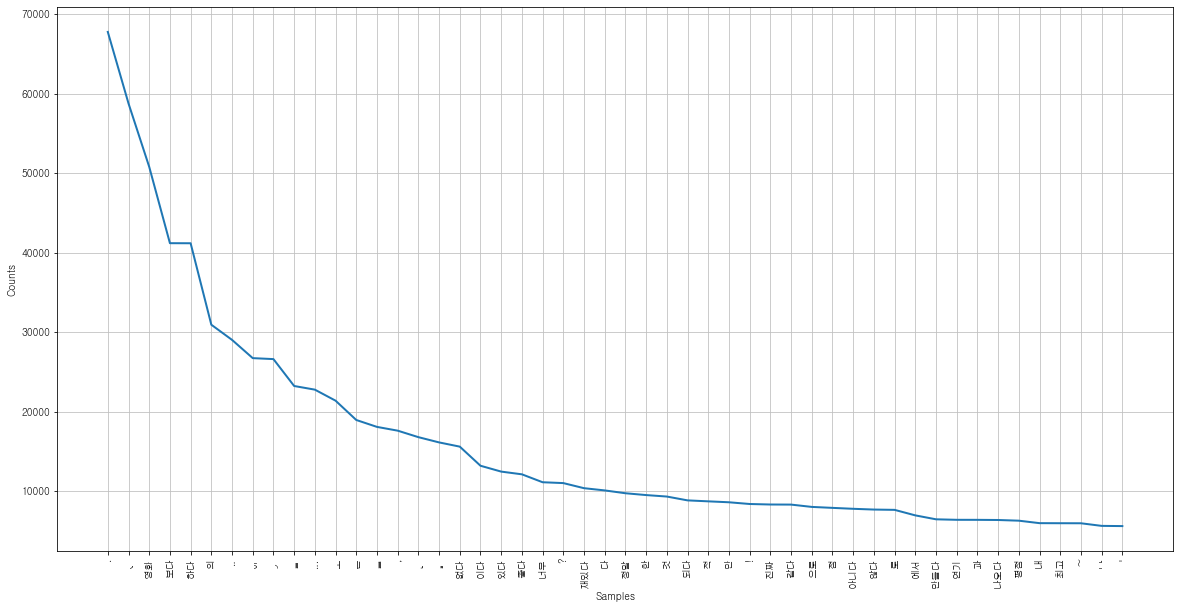

In [37]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [39]:
# 불용어 처리 및 벡터화

selected_words = [f for f,_ in text.vocab().most_common(2000)  if f not in stopwords]
input_length = len(selected_words)

print(input_length)

1863


In [40]:
## 시간이 오래 걸림

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
train_y = [c for _, c in train_docs]

test_x = [term_frequency(d) for d, _ in test_docs]
test_y = [c for _, c in test_docs]

In [46]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

# 위와 같이 CountVectorization 을 하지 않고 one-hot로 해본다면???

In [47]:
x_train.shape

(150000, 1863)

In [48]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics



model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_length,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

print(model.summary())

model.fit(x_train, y_train, epochs=10, batch_size=512)

results = model.evaluate(x_test, y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                119296    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 123,521
Trainable params: 123,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
150000/150000 [==============================] - 3s 19us/sample - loss: 0.4126 - binary_accuracy: 0.8161
Epoch 2/10
150000/150000 [==============================] - 2s 14us/sample - loss: 0.3622 - binary_accuracy: 0.8365
Epoch 3/10
150000/150000 [==============================] - 2s 14us/sample - loss: 0.3480 - binary_accuracy: 0.8450
Epoch 4/10
150000/150000 

In [70]:
results

[0.3892919591856003, 0.83502]

In [50]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

In [37]:
predict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")
predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")
predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")
predict_pos_neg("주연배우 때문에 봤어요 근데 너무너무 구리네요")

[올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.]는 98.85% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.]는 81.55% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;

[주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ]는 80.16% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[믿고 보는 감독이지만 이번에는 아니네요]는 82.37% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;

[주연배우 때문에 봤어요 근데 너무너무 구리네요]는 53.32% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;



In [51]:
"""
# bidirection LSTM??? 


from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb



model = Sequential()
# model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])
          
"""

"\n# bidirection LSTM??? \n\n\nfrom keras.preprocessing import sequence\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional\nfrom keras.datasets import imdb\n\n\n\nmodel = Sequential()\n# model.add(Embedding(max_features, 128, input_length=maxlen))\nmodel.add(Bidirectional(LSTM(64)))\nmodel.add(Dense(1, activation='sigmoid'))\n\nprint(model.summary())\n# try using different optimizers and different optimizer configs\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nprint('Train...')\nmodel.fit(x_train, y_train,\n          batch_size=batch_size,\n          epochs=4,\n          validation_data=[x_test, y_test])\n          \n"

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(tokenizer = okt.morphs, ngram_range= (1,2), min_df=3, max_df=0.9)
tfv.fit(train_x)
tfv_train_x = tfv.transform(train_x)
tfv_train_x

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
from sklearn.linear_model import LogisticRegression # 이진분류
from sklearn.model_selection import GridSearchCV # 하이퍼 파라미터 최적화??

clf = LogisticRegression(random_state=0)
params = {'C' : [1,3,5,7,9]} 
grid_cv = GridSearchCV(clf, param_grid=params, cv=4, scoring='accuracy', verbose=1) 
grid_cv.fit(tfv_train_x, train_y)



In [ ]:
grid_cv.best_params_ 

In [ ]:
grid_cv.best_score_

In [ ]:
tfv_test_x = tfv.transform(test_x)
grid_cv.best_estimator_.score(tfv_test_x, test_y)

In [ ]:
a = ['아너무 재미없네요 꼭 보세요']
my_review = tfv.transform(a)
grid_cv.best_estimator_.predict(my_review)